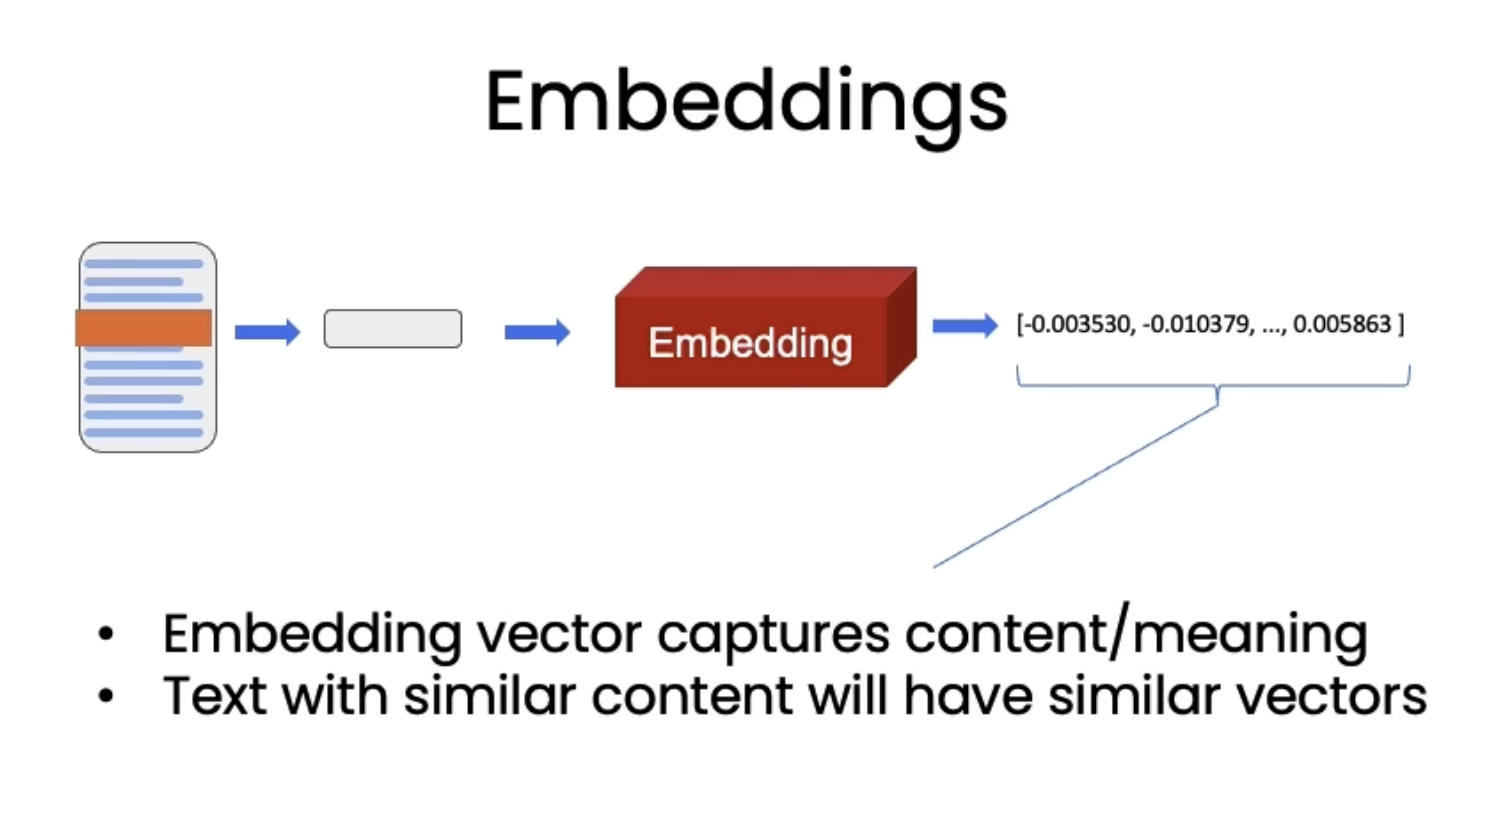

In [1]:
from dotenv import load_dotenv , find_dotenv

_ = load_dotenv(find_dotenv())

In [1]:
from langchain.document_loaders import PyPDFLoader

loaders  = [
    PyPDFLoader("ml_doc1.pdf"), 
    PyPDFLoader("ml_doc1.pdf"), # load duplicate for unclean data
    PyPDFLoader("ml_doc2.pdf"),
    PyPDFLoader("ml_doc3.pdf")
]

pdf_pages = []

for loader in loaders:
    pdf_pages.extend(loader.load())


In [2]:
# Splitter 
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [4]:
splits = text_splitter.split_documents(pdf_pages)

In [5]:
len(splits)

209

In [6]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings() # client for ada-002 api

In [7]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [8]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [9]:
import numpy as np

In [13]:
np.dot(embedding1, embedding2) # closer to 1 , most similar

0.9631834174162256

In [11]:
np.dot(embedding1, embedding3)

0.7709998074536494

In [12]:
np.dot(embedding2, embedding3)

0.7596998226928795

## Vectorstores

In [14]:
from langchain.vectorstores import Chroma # use pip install chromadb

In [15]:
persist_directory = 'db/chroma/'

In [16]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
) # embedding API , creates vector for each doc chunk 

In [18]:
print(vectordb._collection.count()) # same as the number of splits of documents

209


In [19]:
question = "is there an email i can ask for help"

In [20]:
answer_chunks = docs = vectordb.similarity_search(question,k=3)

In [21]:
print(answer_chunks[0])

page_content="cs229-qa@cs.stanford.edu. This goes to an acc ount that's read by all the TAs and me. So \nrather than sending us email individually, if you send email to this account, it will \nactually let us get back to you maximally quickly with answers to your questions.  \nIf you're asking questions about homework probl ems, please say in the subject line which \nassignment and which question the email refers to, since that will also help us to route \nyour question to the appropriate TA or to me  appropriately and get the response back to \nyou quickly.  \nLet's see. Skipping ahead — let's see — for homework, one midterm, one open and term \nproject. Notice on the honor code. So one thi ng that I think will help you to succeed and \ndo well in this class and even help you to enjoy this cla ss more is if you form a study \ngroup.  \nSo start looking around where you' re sitting now or at the end of class today, mingle a \nlittle bit and get to know your classmates. I strongly encou

In [22]:
vectordb.persist()

## Failure modes

This seems great, and basic similarity search will get you 80% of the way there very easily. 

But there are some failure modes that can creep up. 

Here are some edge cases that can arise - we'll fix them in the next class.

In [23]:
question = "what did they say about matlab?"

In [24]:
docs = vectordb.similarity_search(question,k=5)

Notice that we're getting duplicate chunks (because of the duplicate `MachineLearning-Lecture01.pdf` in the index).

Semantic search fetches all similar documents, but does not enforce diversity.

`docs[0]` and `docs[1]` are indentical.

In [25]:
docs[0].page_content == docs[1].page_content

True

In [26]:
question = "what did they say about regression in the third lecture?"

In [27]:
docs = vectordb.similarity_search(question,k=7)

In [28]:
for doc in docs:
    print(doc.metadata)

{'page': 0, 'source': 'ml_doc3.pdf'}
{'page': 14, 'source': 'ml_doc3.pdf'}
{'page': 0, 'source': 'ml_doc2.pdf'}
{'page': 6, 'source': 'ml_doc3.pdf'}
{'page': 8, 'source': 'ml_doc1.pdf'}
{'page': 8, 'source': 'ml_doc1.pdf'}
{'page': 13, 'source': 'ml_doc3.pdf'}


even though question is specific about third lecture , but the information is stored in metadata 

also as you increase `k` the latter documents will have less relevant informations as most simliar vectors are returned first